# Initial Modeling - AdVitam Sleepiness Dataset

This notebook performs initial machine learning modeling on the AdVitam Experiment 4 dataset for sleepiness detection using physiological signals.

**Objective**: Predict KSS (Karolinska Sleepiness Scale) scores using physiological features

**Approach**: Regression modeling with multiple algorithms


## 1. Setup

Load necessary libraries and initialize the dataset class.


In [ ]:
import sys, pathlib

project_root = pathlib.Path.cwd().parent       # notebooks → repo root
src_path     = project_root / "src"            # holds the actual code

# allow `from data.*` (needs src/ on the path)
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# optional: also allow `from src.*`
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import GroupShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Dataset class
from data.sleepiness_dataset import SleepinessDataset

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Configuration
CONFIG = {
    # Global settings
    'random_state': 42,
    'test_size': 0.2,
    
    # Columns to drop
    'columns_to_drop': ['subject_id', 'first_scenario', 'period', 'label_sleep', 'label_time_exp'],
    
    # Model hyperparameters
    'models': {
        'linear_regression': {},
        'decision_tree': {
            'max_depth': 10,
            'min_samples_split': 20,
            'min_samples_leaf': 10
        }
    }
}

# Set random seed for reproducibility
np.random.seed(CONFIG['random_state'])

print("Configuration loaded successfully!")
print(f"Random state: {CONFIG['random_state']}")
print(f"Test size: {CONFIG['test_size']}")
print(f"Models configured: {list(CONFIG['models'].keys())}")


Configuration loaded successfully!
Random state: 42
Test size: 0.2
Models configured: ['linear_regression', 'decision_tree']


## Load the dataset


In [ ]:
dataset = SleepinessDataset()
df = dataset.load()

print(f"\nDataset shape: {df.shape}")
print(f"Features: {len(dataset.feature_cols)}")
print(f"Subjects: {df['subject_id'].nunique()}") 


Dataset shape: (599, 130)
Features: 123
Subjects: 60


In [ ]:
# Examine the dataset structure
print("Dataset overview:")
df.head()


Dataset overview:


,subject_id,label_sleep,first_scenario,label_time_exp,period,segment_id,EDA_filtered_mean_Dr-Bl,EDA_filtered_min_Dr-Bl,EDA_filtered_max_Dr-Bl,EDA_filtered_std_Dr-Bl,...,SCR_Peaks_Amplitude_Mean_Dr-Bl,RSA_P2T_Mean_Dr-Bl,RSA_P2T_Mean_log_Dr-Bl,RSA_P2T_SD_Dr-Bl,RSA_P2T_NoRSA_Dr-Bl,RSA_PorgesBohrer_Dr-Bl,RSA_Gates_Mean_Dr-Bl,RSA_Gates_Mean_log_Dr-Bl,RSA_Gates_SD_Dr-Bl,kss
0,1,0,Rural,16,Rural,0,6.240796,5.929979,6.341950,0.089752,...,0.157879,-0.003551,-0.116674,0.001146,0.0,0.400630,-0.231271,-0.029140,0.012048,4.00
1,1,0,Rural,16,Rural,1,4.933697,4.806328,4.407790,-0.002111,...,0.012626,-0.003768,-0.124247,-0.000265,0.0,0.175800,-0.171799,-0.021565,0.015757,3.75
2,1,0,Rural,16,Rural,2,5.188408,5.132712,5.517033,0.033235,...,0.254859,-0.001096,-0.034572,0.007145,0.0,0.303468,-0.171153,-0.021484,0.015238,3.50
3,1,0,Rural,16,Rural,3,4.416023,4.516889,3.809360,-0.091715,...,-0.075401,-0.002492,-0.080434,0.006244,0.0,0.167533,-0.118763,-0.014858,0.017757,3.25
4,1,0,Rural,16,Rural,4,3.858262,3.911289,3.446269,-0.115461,...,-0.125719,-0.001319,-0.041778,0.005092,0.0,0.210252,-0.136638,-0.017114,0.015136,3.00


KSS (target) distribution:
count    599.000000
mean       5.680301
std        1.842300
min        1.000000
25%        4.000000
50%        6.000000
75%        7.000000
max       10.000000
Name: kss, dtype: float64


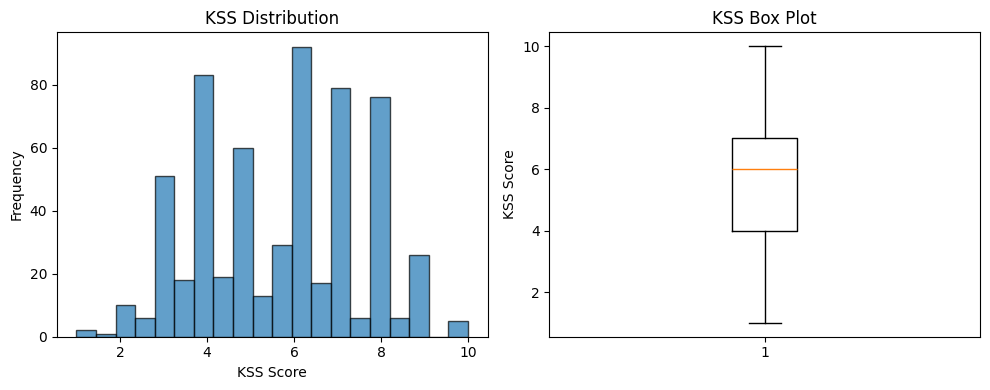

In [ ]:
# Check target variable distribution
print("KSS (target) distribution:")
print(df['kss'].describe())

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['kss'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('KSS Score')
plt.ylabel('Frequency')
plt.title('KSS Distribution')

plt.subplot(1, 2, 2)
plt.boxplot(df['kss'])
plt.ylabel('KSS Score')
plt.title('KSS Box Plot')

plt.tight_layout()
plt.show()


## 2. Preprocessing

Prepare the data for machine learning by handling missing values, feature selection, and train/test splitting.


In [ ]:
# Check missing values
print("Missing values in dataset:")
missing_info = df.isnull().sum()
missing_features = missing_info[missing_info > 0]
if len(missing_features) > 0:
    print(f"Features with missing values: {len(missing_features)}")
    print(missing_features.head(10))
else:
    print("No missing values found.")


Missing values in dataset:
Features with missing values: 15
HRV_SDANN1_Dr-Bl                 25
HRV_SDNNI1_Dr-Bl                 25
HRV_LF_Dr-Bl                      4
HRV_LFHF_Dr-Bl                    4
HRV_LFn_Dr-Bl                     4
HRV_DFA_alpha1_ExpRange_Dr-Bl     6
HRV_DFA_alpha1_ExpMean_Dr-Bl      6
HRV_DFA_alpha1_DimRange_Dr-Bl     6
HRV_DFA_alpha1_DimMean_Dr-Bl      6
HRV_MSE_Dr-Bl                     4
dtype: int64


In [ ]:
# Prepare features and target
# Drop irrelevant columns from config
available_drops = [col for col in CONFIG['columns_to_drop'] if col in df.columns]

print(f"Dropping columns: {available_drops}")

# Create feature matrix (X) and target vector (y)
X = df.drop(columns=available_drops + ['kss', 'segment_id'])
y = df['kss']
subjects = df['subject_id']  # Keep for group-based splitting

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Feature columns: {list(X.columns[:5])}...")  # Show first 5 features


Dropping columns: ['subject_id', 'first_scenario', 'period', 'label_sleep', 'label_time_exp']

Feature matrix shape: (599, 123)
Target vector shape: (599,)
Feature columns: ['EDA_filtered_mean_Dr-Bl', 'EDA_filtered_min_Dr-Bl', 'EDA_filtered_max_Dr-Bl', 'EDA_filtered_std_Dr-Bl', 'EDA_tonic_mean_Dr-Bl']...


In [ ]:
# Group-based train/test split using GroupShuffleSplit
# Ensure no subject appears in both training and test sets
print(f"Total unique subjects: {subjects.nunique()}")

# Use GroupShuffleSplit for proper group-based splitting
gss = GroupShuffleSplit(
    n_splits=1, 
    test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_state']
)

# Get the train/test indices
train_idx, test_idx = next(gss.split(X, y, groups=subjects))

# Split the data
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

print(f"Train subjects: {subjects.iloc[train_idx].nunique()}")
print(f"Test subjects: {subjects.iloc[test_idx].nunique()}")
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train/test ratio: {X_train.shape[0]/X_test.shape[0]:.1f}")


Total unique subjects: 60
Train subjects: 48
Test subjects: 12

Training set: 479 samples
Test set: 120 samples
Train/test ratio: 4.0


=== Training vs Test Set Statistics ===

KSS Distribution:
Training set - Mean: 5.511, Std: 1.887
Test set     - Mean: 6.354, Std: 1.476


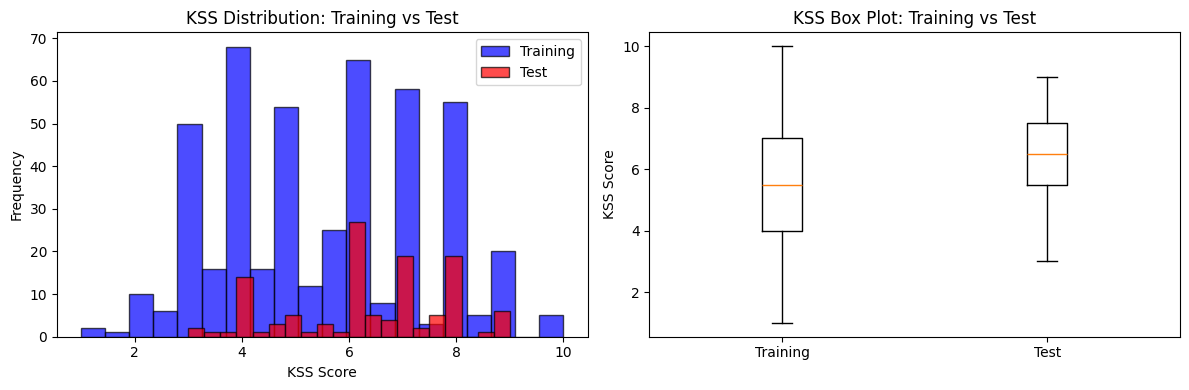


Subject overlap between train/test: 0 subjects
✓ No subject overlap - proper group-based split achieved!


In [ ]:
# Compare training and test set distributions
print("=== Training vs Test Set Statistics ===")

print(f"\nKSS Distribution:")
print(f"Training set - Mean: {y_train.mean():.3f}, Std: {y_train.std():.3f}")
print(f"Test set     - Mean: {y_test.mean():.3f}, Std: {y_test.std():.3f}")

# Plot KSS histograms
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=20, alpha=0.7, label='Training', color='blue', edgecolor='black')
plt.hist(y_test, bins=20, alpha=0.7, label='Test', color='red', edgecolor='black')
plt.xlabel('KSS Score')
plt.ylabel('Frequency')
plt.title('KSS Distribution: Training vs Test')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot([y_train, y_test], labels=['Training', 'Test'])
plt.ylabel('KSS Score')
plt.title('KSS Box Plot: Training vs Test')

plt.tight_layout()
plt.show()

# Check for overlap in subjects (should be zero)
train_subjects_set = set(subjects.iloc[train_idx])
test_subjects_set = set(subjects.iloc[test_idx])
overlap = train_subjects_set.intersection(test_subjects_set)
print(f"\nSubject overlap between train/test: {len(overlap)} subjects")
if len(overlap) > 0:
    print(f"Overlapping subjects: {overlap}")
else:
    print("✓ No subject overlap - proper group-based split achieved!")


In [ ]:
X_train.isna().sum()

EDA_filtered_mean_Dr-Bl     0
EDA_filtered_min_Dr-Bl      0
EDA_filtered_max_Dr-Bl      0
EDA_filtered_std_Dr-Bl      0
EDA_tonic_mean_Dr-Bl        0
                           ..
RSA_P2T_NoRSA_Dr-Bl         0
RSA_PorgesBohrer_Dr-Bl      0
RSA_Gates_Mean_Dr-Bl        0
RSA_Gates_Mean_log_Dr-Bl    0
RSA_Gates_SD_Dr-Bl          4
Length: 123, dtype: int64

### Handling infinite values

In [ ]:
# Check for infinite values in your DataFrame
inf_mask = np.isinf(X_train).any(axis=1)
rows_with_inf = X_train[inf_mask]
print(f"Number of rows with infinite values: {len(rows_with_inf)}")

# To see which specific columns have infinite values
inf_cols = X_train.columns[np.isinf(X_train).any(axis=0)]
print(f"Columns with infinite values: {list(inf_cols)}")

Number of rows with infinite values: 19
Columns with infinite values: ['HRV_SampEn_Dr-Bl', 'RRV_SampEn_Dr-Bl']


In [ ]:
# Just drop for now
inf_mask = np.isinf(X_train).any(axis=1)
print(f"Rows with infinite values only: {inf_mask.sum()}")
print(f"Dropping {inf_mask.sum()} out of {len(X_train)} training samples")

Rows with infinite values only: 19
Dropping 19 out of 479 training samples


In [ ]:
# Apply the mask to remove rows with infinite values
X_train = X_train[~inf_mask]
y_train = y_train[~inf_mask]

In [ ]:
X_train

,EDA_filtered_mean_Dr-Bl,EDA_filtered_min_Dr-Bl,EDA_filtered_max_Dr-Bl,EDA_filtered_std_Dr-Bl,EDA_tonic_mean_Dr-Bl,EDA_tonic_min_Dr-Bl,EDA_tonic_max_Dr-Bl,EDA_tonic_std_Dr-Bl,SCR_Peaks_freq_Dr-Bl,ECG_Rate_Mean_Dr-Bl,...,SCR_Peaks_N_Dr-Bl,SCR_Peaks_Amplitude_Mean_Dr-Bl,RSA_P2T_Mean_Dr-Bl,RSA_P2T_Mean_log_Dr-Bl,RSA_P2T_SD_Dr-Bl,RSA_P2T_NoRSA_Dr-Bl,RSA_PorgesBohrer_Dr-Bl,RSA_Gates_Mean_Dr-Bl,RSA_Gates_Mean_log_Dr-Bl,RSA_Gates_SD_Dr-Bl
10,3.050172,3.228824,1.635160,-0.127007,3.049097,3.215845,1.931039,-0.154166,-0.013612,3.007846,...,-11.0,0.013187,0.011382,0.175383,-0.018568,-1.0,0.471671,-0.010933,-0.001363,-0.018582
11,4.755602,3.257000,5.239554,0.417812,4.756211,3.450799,4.563580,0.369263,2.918919,7.298359,...,-4.0,0.258978,0.031277,0.423158,0.019789,2.0,0.516436,-0.152589,-0.019199,0.040270
12,3.949644,4.558174,1.444016,-0.643541,3.947693,4.706717,1.653453,-0.745344,4.175717,8.091090,...,-1.0,-0.045787,0.010203,0.158585,0.002423,2.0,0.598682,-0.106298,-0.013335,0.026767
13,3.921474,4.114747,1.663593,-0.458358,3.926490,4.067097,1.800656,-0.469497,0.405321,5.394103,...,-10.0,-0.104103,0.018420,0.270205,0.013661,-3.0,0.386920,-0.103094,-0.012931,0.030842
14,2.228403,3.174230,-0.948780,-0.778926,2.226285,3.127655,-0.105639,-0.757965,-0.013612,3.577821,...,-11.0,-0.465313,0.017363,0.256534,-0.002856,-2.0,0.018148,-0.089638,-0.011234,-0.039889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,4.297119,5.765870,1.458715,-0.944292,4.309581,5.866243,2.940090,-0.922715,1.442992,-1.313895,...,4.0,-0.334532,0.057900,0.473816,0.059633,-3.0,0.403092,0.257815,0.029952,0.250294
595,3.877850,5.888398,0.597394,-1.200589,3.888736,5.959121,2.219355,-1.175188,2.262723,-0.755601,...,8.0,-0.375906,0.089367,0.660375,0.125910,0.0,1.054768,0.352011,0.040675,0.155602
596,3.138770,5.231840,-0.370577,-1.247061,3.155241,5.257946,1.327198,-1.208949,3.697252,0.327703,...,15.0,-0.437024,0.059218,0.482372,0.091724,-2.0,0.764430,0.256710,0.029825,0.162742
597,2.857083,4.314966,-0.519343,-1.274155,2.867241,4.706744,1.205181,-1.246514,0.828194,0.802624,...,1.0,-0.405648,0.021507,0.203057,0.042716,0.0,0.459075,0.133118,0.015577,0.139558


In [ ]:
# Just drop for now
inf_mask = np.isinf(X_test).any(axis=1)
print(f"Rows with infinite values only: {inf_mask.sum()}")
print(f"Dropping {inf_mask.sum()} out of {len(X_test)} training samples")

X_test = X_test[~inf_mask]
y_test = y_test[~inf_mask]

Rows with infinite values only: 2
Dropping 2 out of 120 training samples


### Handling missing values


In [ ]:
# Use median imputation for numerical features
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"Missing values after imputation:")
print(f"Train: {X_train_imputed.isnull().sum().sum()}")
print(f"Test: {X_test_imputed.isnull().sum().sum()}")

# Metrics calculation function
def calculate_metrics(y_true, y_pred, dataset_name=""):
    """Calculate and return regression metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'dataset': dataset_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }


Missing values after imputation:
Train: 0
Test: 0


In [ ]:
# Feature scaling for algorithms that benefit from it
print("Scaling features...")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

print(f"Feature scaling completed.")
print(f"Train features mean: {X_train_scaled.mean().mean():.6f}")
print(f"Train features std: {X_train_scaled.std().mean():.6f}")


Scaling features...
Feature scaling completed.
Train features mean: -0.000000
Train features std: 0.960394


## 3. Baseline Model - Driving

Train and evaluate multiple regression algorithms to predict KSS scores using driving features only (delta features: Dr-Bl).


### 3.1 Linear Regression


In [ ]:
# Linear Regression
lr_model = LinearRegression(**CONFIG['models']['linear_regression'])
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# Calculate metrics
lr_train_metrics = calculate_metrics(y_train, lr_train_pred, "Train")
lr_test_metrics = calculate_metrics(y_test, lr_test_pred, "Test")

print(f"Linear Regression Results:")
print(f"Train RMSE: {lr_train_metrics['rmse']:.4f}, Test RMSE: {lr_test_metrics['rmse']:.4f}")
print(f"Train MAE: {lr_train_metrics['mae']:.4f}, Test MAE: {lr_test_metrics['mae']:.4f}")
print(f"Train R²: {lr_train_metrics['r2']:.4f}, Test R²: {lr_test_metrics['r2']:.4f}")


Linear Regression Results:
Train RMSE: 1.1116, Test RMSE: 2.3490
Train MAE: 0.8907, Test MAE: 1.7918
Train R²: 0.6599, Test R²: -1.5132


### 3.2 Decision Tree


In [ ]:
# Decision Tree Regressor
dt_model = DecisionTreeRegressor(
    random_state=CONFIG['random_state'],
    **CONFIG['models']['decision_tree']
)
dt_model.fit(X_train_imputed, y_train)  # Use unscaled data for tree

# Predictions
dt_train_pred = dt_model.predict(X_train_imputed)
dt_test_pred = dt_model.predict(X_test_imputed)

# Calculate metrics
dt_train_metrics = calculate_metrics(y_train, dt_train_pred, "Train")
dt_test_metrics = calculate_metrics(y_test, dt_test_pred, "Test")

print(f"Decision Tree Results:")
print(f"Train RMSE: {dt_train_metrics['rmse']:.4f}, Test RMSE: {dt_test_metrics['rmse']:.4f}")
print(f"Train MAE: {dt_train_metrics['mae']:.4f}, Test MAE: {dt_test_metrics['mae']:.4f}")
print(f"Train R²: {dt_train_metrics['r2']:.4f}, Test R²: {dt_test_metrics['r2']:.4f}")


Decision Tree Results:
Train RMSE: 1.0155, Test RMSE: 2.1486
Train MAE: 0.7628, Test MAE: 1.7713
Train R²: 0.7161, Test R²: -1.1028


## 4. Baseline Model - Driving with Baseline

Train and evaluate the same algorithms but now using all available features (driving + baseline + delta).


### 4.1 Load Dataset with All Features


In [ ]:

# Load dataset with all features (driving + baseline + delta)
dataset_all = SleepinessDataset(feature_type="all")
df_all = dataset_all.load()

print(f"\nDataset with all features shape: {df_all.shape}")
print(f"Features: {len(dataset_all.feature_cols)}")
print(f"Subjects: {df_all['subject_id'].nunique()}")

# Verify same subjects and data structure
assert df_all['subject_id'].nunique() == df['subject_id'].nunique(), "Different number of subjects!"
print("✓ Same subjects confirmed")

# Check feature types
driving_features = [c for c in dataset_all.feature_cols if c.endswith('_Dr') and not c.endswith('_Dr-Bl')]
baseline_features = [c for c in dataset_all.feature_cols if c.endswith('_Bl')]
delta_features = [c for c in dataset_all.feature_cols if c.endswith('_Dr-Bl')]

print(f"\nFeature breakdown:")
print(f"  Driving features: {len(driving_features)}")
print(f"  Baseline features: {len(baseline_features)}")
print(f"  Delta features: {len(delta_features)}")
print(f"  Total: {len(driving_features) + len(baseline_features) + len(delta_features)}")

# Prepare features for all-features experiment
available_drops_all = [col for col in CONFIG['columns_to_drop'] if col in df_all.columns]
X_all = df_all.drop(columns=available_drops_all + ['kss', 'segment_id'])
y_all = df_all['kss']
subjects_all = df_all['subject_id']

print(f"\nAll-features matrix shape: {X_all.shape}")
print(f"Target vector shape: {y_all.shape}")

# Use the same train/test split as before (same subjects)
X_all_train = X_all.iloc[train_idx]
X_all_test = X_all.iloc[test_idx]
y_all_train = y_all.iloc[train_idx]
y_all_test = y_all.iloc[test_idx]

print(f"\nAll-features training set: {X_all_train.shape[0]} samples, {X_all_train.shape[1]} features")
print(f"All-features test set: {X_all_test.shape[0]} samples, {X_all_test.shape[1]} features")



Dataset with all features shape: (599, 380)
Features: 373
Subjects: 60
✓ Same subjects confirmed

Feature breakdown:
  Driving features: 125
  Baseline features: 125
  Delta features: 123
  Total: 373

All-features matrix shape: (599, 373)
Target vector shape: (599,)

All-features training set: 479 samples, 373 features
All-features test set: 120 samples, 373 features


### 4.2 Preprocessing for All Features


In [ ]:

# Remove rows with infinite values
inf_mask = np.isinf(X_all_train).any(axis=1)
print(f"Rows with infinite values only: {inf_mask.sum()}")
print(f"Dropping {inf_mask.sum()} out of {len(X_all_train)} training samples")
X_all_train = X_all_train[~inf_mask]
y_all_train = y_all_train[~inf_mask]


inf_mask = np.isinf(X_all_test).any(axis=1)
print(f"Rows with infinite values only: {inf_mask.sum()}")
print(f"Dropping {inf_mask.sum()} out of {len(X_all_test)} training samples")
X_all_test = X_all_test[~inf_mask]
y_all_test = y_all_test[~inf_mask]

# Handle missing values for all-features dataset
print("Handling missing values for all-features dataset...")

# Use median imputation for numerical features
imputer_all = SimpleImputer(strategy='median')
X_all_train_imputed = pd.DataFrame(
    imputer_all.fit_transform(X_all_train),
    columns=X_all_train.columns,
    index=X_all_train.index
)
X_all_test_imputed = pd.DataFrame(
    imputer_all.transform(X_all_test),
    columns=X_all_test.columns,
    index=X_all_test.index
)

print(f"Missing values after imputation:")
print(f"Train: {X_all_train_imputed.isnull().sum().sum()}")
print(f"Test: {X_all_test_imputed.isnull().sum().sum()}")

# Feature scaling for algorithms that benefit from it
print("Scaling features for all-features dataset...")

scaler_all = StandardScaler()
X_all_train_scaled = pd.DataFrame(
    scaler_all.fit_transform(X_all_train_imputed),
    columns=X_all_train_imputed.columns,
    index=X_all_train_imputed.index
)
X_all_test_scaled = pd.DataFrame(
    scaler_all.transform(X_all_test_imputed),
    columns=X_all_test_imputed.columns,
    index=X_all_test_imputed.index
)

print(f"All-features scaling completed.")
print(f"Train features mean: {X_all_train_scaled.mean().mean():.6f}")
print(f"Train features std: {X_all_train_scaled.std().mean():.6f}")


Rows with infinite values only: 19
Dropping 19 out of 479 training samples
Rows with infinite values only: 2
Dropping 2 out of 120 training samples
Handling missing values for all-features dataset...
Missing values after imputation:
Train: 0
Test: 0
Scaling features for all-features dataset...
All-features scaling completed.
Train features mean: -0.000000
Train features std: 0.987669


### 4.3 Model Training with All Features


In [ ]:

# Train all models with all features using the same hyperparameters

# Linear Regression with all features
lr_all_model = LinearRegression(**CONFIG['models']['linear_regression'])
lr_all_model.fit(X_all_train_scaled, y_all_train)

lr_all_train_pred = lr_all_model.predict(X_all_train_scaled)
lr_all_test_pred = lr_all_model.predict(X_all_test_scaled)

lr_all_train_metrics = calculate_metrics(y_all_train, lr_all_train_pred, "Train_All")
lr_all_test_metrics = calculate_metrics(y_all_test, lr_all_test_pred, "Test_All")

print(f"Linear Regression (All Features) Results:")
print(f"Train RMSE: {lr_all_train_metrics['rmse']:.4f}, Test RMSE: {lr_all_test_metrics['rmse']:.4f}")
print(f"Train MAE: {lr_all_train_metrics['mae']:.4f}, Test MAE: {lr_all_test_metrics['mae']:.4f}")
print(f"Train R²: {lr_all_train_metrics['r2']:.4f}, Test R²: {lr_all_test_metrics['r2']:.4f}")

# Decision Tree with all features
dt_all_model = DecisionTreeRegressor(
    random_state=CONFIG['random_state'],
    **CONFIG['models']['decision_tree']
)
dt_all_model.fit(X_all_train_imputed, y_all_train)

dt_all_train_pred = dt_all_model.predict(X_all_train_imputed)
dt_all_test_pred = dt_all_model.predict(X_all_test_imputed)

dt_all_train_metrics = calculate_metrics(y_all_train, dt_all_train_pred, "Train_All")
dt_all_test_metrics = calculate_metrics(y_all_test, dt_all_test_pred, "Test_All")

print(f"\nDecision Tree (All Features) Results:")
print(f"Train RMSE: {dt_all_train_metrics['rmse']:.4f}, Test RMSE: {dt_all_test_metrics['rmse']:.4f}")
print(f"Train MAE: {dt_all_train_metrics['mae']:.4f}, Test MAE: {dt_all_test_metrics['mae']:.4f}")
print(f"Train R²: {dt_all_train_metrics['r2']:.4f}, Test R²: {dt_all_test_metrics['r2']:.4f}")




Linear Regression (All Features) Results:
Train RMSE: 0.5661, Test RMSE: 3.4144
Train MAE: 0.4431, Test MAE: 2.6578
Train R²: 0.9118, Test R²: -4.3099

Decision Tree (All Features) Results:
Train RMSE: 0.6245, Test RMSE: 2.5195
Train MAE: 0.4483, Test MAE: 2.0888
Train R²: 0.8926, Test R²: -1.8914


## 5. Results Summary

In [ ]:
# Create comprehensive results summary table comparing both feature sets
results_data = {
    'Algorithm': ['Linear Regression', 'Decision Tree'] * 2,
    'Feature_Set': ['Delta (Dr-Bl)'] * 2 + ['All (Dr+Bl+Dr-Bl)'] * 2,
    'N_Features': [X.shape[1]] * 2 + [X_all.shape[1]] * 2,
    'Train_RMSE': [lr_train_metrics['rmse'], dt_train_metrics['rmse']] +
                  [lr_all_train_metrics['rmse'], dt_all_train_metrics['rmse']],
    'Test_RMSE': [lr_test_metrics['rmse'], dt_test_metrics['rmse']] +
                 [lr_all_test_metrics['rmse'], dt_all_test_metrics['rmse']],
    'Train_MAE': [lr_train_metrics['mae'], dt_train_metrics['mae']] +
                 [lr_all_train_metrics['mae'], dt_all_train_metrics['mae']],
    'Test_MAE': [lr_test_metrics['mae'], dt_test_metrics['mae']] +
                [lr_all_test_metrics['mae'], dt_all_test_metrics['mae']],
    'Train_R2': [lr_train_metrics['r2'], dt_train_metrics['r2']] +
                [lr_all_train_metrics['r2'], dt_all_train_metrics['r2']],
    'Test_R2': [lr_test_metrics['r2'], dt_test_metrics['r2']] +
               [lr_all_test_metrics['r2'], dt_all_test_metrics['r2']]
}

results_df = pd.DataFrame(results_data)

# Round to 4 decimal places
numeric_cols = ['Train_RMSE', 'Test_RMSE', 'Train_MAE', 'Test_MAE', 'Train_R2', 'Test_R2']
results_df[numeric_cols] = results_df[numeric_cols].round(4)

print("\n=== COMPREHENSIVE MODEL PERFORMANCE SUMMARY ===")
print(results_df.to_string(index=False))

# Create separate tables for easier comparison
# print("\n=== DELTA FEATURES ONLY (Dr-Bl) ===")
# delta_results = results_df[results_df['Feature_Set'] == 'Delta (Dr-Bl)'].copy()
# print(delta_results[['Algorithm', 'N_Features', 'Test_RMSE', 'Test_MAE', 'Test_R2']].to_string(index=False))

# print("\n=== ALL FEATURES (Dr+Bl+Dr-Bl) ===")
# all_results = results_df[results_df['Feature_Set'] == 'All (Dr+Bl+Dr-Bl)'].copy()
# print(all_results[['Algorithm', 'N_Features', 'Test_RMSE', 'Test_MAE', 'Test_R2']].to_string(index=False))



=== COMPREHENSIVE MODEL PERFORMANCE SUMMARY ===
        Algorithm       Feature_Set  N_Features  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2
Linear Regression     Delta (Dr-Bl)         123      1.1116     2.3490     0.8907    1.7918    0.6599  -1.5132
    Decision Tree     Delta (Dr-Bl)         123      1.0155     2.1486     0.7628    1.7713    0.7161  -1.1028
Linear Regression All (Dr+Bl+Dr-Bl)         373      0.5661     3.4144     0.4431    2.6578    0.9118  -4.3099
    Decision Tree All (Dr+Bl+Dr-Bl)         373      0.6245     2.5195     0.4483    2.0888    0.8926  -1.8914
